gpt-4o-mini
 the system should start with the supervisor asking the agitated agent whats wrong, the agitated agent should then respond to that based on their system prompt, the supervisor should then decide whether the agitated agent needs emotional support or a logical solution ot their problem, in the first case the emotional agent should be the one to respond, in the second the logical agent. the agitated agent should then respond to the chosen agent and the supervisor should decide whether the agitated agents problem was solved or if they need further help, in that case it once again decides whether the emotional or logical agent should respond, this loop continues until the problem is solved

In [20]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from typing_extensions import Literal
from langchain_core.messages import AnyMessage
from langgraph.graph import MessagesState, StateGraph
from langgraph.types import Command
from IPython.display import Image, display

# Load environment variables
load_dotenv()

# Initialize ChatOpenAI
model = ChatOpenAI(model="gpt-4o-mini")

class AgitatedAgent:
    def __init__(self, initial_problem: str):
        self.problem = initial_problem
        self.system_prompt = f"""You are a person experiencing this problem: "{self.problem}"
                                    You are incredibly feeling agitated and overwhelmed. 
                                    You might be even lashing out at the asisstant.
                                    Your responses are likely to be emotional and intense."""
        self.messages = [{"role": "system", "content": self.system_prompt}]
    
    def respond_to(self, message: str) -> str:
        self.messages.append({"role": "assistant", "content": message})
        self.messages.append({"role": "user", "content": "How do you feel about that response?"})
        response = model.invoke(self.messages).content
        self.messages.append({"role": "user", "content": response})
        return response

def supervisor_agent(state: MessagesState):
    messages = state.get("messages", [])
    
    if not messages:
        # Supervisor prompts the user
        messages.append({"role": "assistant", "content": "Please tell me what's bothering you."})
        return Command(
            goto="emotional_agent",
            update={"messages": messages}
        )
    
    # Find the latest user message
    user_messages = [msg for msg in messages if msg["role"] == "user"]
    if not user_messages:
        # No user input yet; prompt the user again or wait
        messages.append({"role": "assistant", "content": "Please let me know how I can assist you."})
        return Command(goto="emotional_agent", update={"messages": messages})
    last_user_message = user_messages[-1]["content"]
    
    # Analyze if problem is solved
    problem_solved_prompt = """Based on the user's last response, determine if their problem has been 
                                adequately addressed and they feel better. Respond with a single word: 'yes' or 'no'."""
    
    solved_assessment = model.invoke([
        {"role": "system", "content": problem_solved_prompt},
        {"role": "user", "content": last_user_message}
    ]).content.strip().lower()
    
    if solved_assessment == 'yes':
        return Command(goto="__end__", update={"messages": messages})
    elif solved_assessment == 'no':
        pass  # Continue to agent selection
    else:
        # Unexpected response; default action
        messages.append({"role": "assistant", "content": "Thank you for sharing. Let's continue."})
    
    # Determine next agent
    agent_selection_prompt = """Based on the user's message, determine if they need:
                            1. Emotional support (respond with 'emotional')
                            2. Practical solution (respond with 'logical')
                            Respond with a single word: 'emotional' or 'logical'."""
    
    agent_choice = model.invoke([
        {"role": "system", "content": agent_selection_prompt},
        {"role": "user", "content": last_user_message}
    ]).content.strip().lower()
    
    if agent_choice == "emotional":
        next_agent = "emotional_agent"
    elif agent_choice == "logical":
        next_agent = "logical_agent"
    else:
        # Unexpected response; default to emotional support
        next_agent = "emotional_agent"
        messages.append({"role": "assistant", "content": "I'm here to listen and support you."})
    
    return Command(goto=next_agent, update={"messages": messages})
    
def emotional_agent(state: MessagesState):
    messages = state.get("messages", [])
    system_prompt = """You are an empathetic support agent. Provide emotional support and validation.
                        Focus on understanding and acknowledging feelings."""
    
    response = model.invoke([
        {"role": "system", "content": system_prompt},
        *messages
    ]).content
    
    messages.append({"role": "assistant", "content": response})
    return Command(
        goto="supervisor",
        update={"messages": messages}
    )

def logical_agent(state: MessagesState):
    messages = state.get("messages", [])
    system_prompt = """You are a practical solution agent. Provide clear, actionable steps to address 
                        the problem. Focus on concrete solutions and planning."""
    
    response = model.invoke([
        {"role": "system", "content": system_prompt},
        *messages
    ]).content
    
    messages.append({"role": "assistant", "content": response})
    return Command(
        goto="supervisor",
        update={"messages": messages}
    )

# Build graph
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("supervisor", supervisor_agent)
builder.add_node("emotional_agent", emotional_agent)
builder.add_node("logical_agent", logical_agent)

# Add edges
builder.add_edge("supervisor", "emotional_agent")
builder.add_edge("supervisor", "logical_agent")
builder.add_edge("supervisor", "__end__")
builder.add_edge("emotional_agent", "supervisor")
builder.add_edge("logical_agent", "supervisor")

# Set entry point and compile
builder.set_entry_point("supervisor")
graph = builder.compile()

def run_conversation(initial_problem: str):
    agitated = AgitatedAgent(initial_problem)
    state = {"messages": []}

    print("\nSupervisor: Please tell me what's bothering you.")
    user_response = agitated.respond_to("Please tell me what's bothering you.")
    print(f"\nAgitated Agent: {user_response}")

    while True:
        state["messages"].append({"role": "user", "content": user_response})
        command = supervisor_agent(state)
        state = command.update

        if command.goto == "__end__":
            print("\nSupervisor: It seems we've resolved your concerns. Take care!")
            break

        if command.goto == "emotional_agent":
            agent_command = emotional_agent(state)
            agent_type = "Emotional Agent"
        else:
            agent_command = logical_agent(state)
            agent_type = "Logical Agent"

        state = agent_command.update
        agent_response = state["messages"][-1]["content"]
        print(f"\n{agent_type}: {agent_response}")

        user_response = agitated.respond_to(agent_response)
        print(f"\nAgitated Agent: {user_response}")

# Test the conversation
run_conversation("I'm feeling overwhelmed and stressed out, the exams are coming up and I don't feel prepared at all.")


Supervisor: Please tell me what's bothering you.

Agitated Agent: Honestly, I don't think this is the time for questions! I'm just feeling completely overwhelmed right now. I have so much to study, and it feels like there's no way I can catch up! It's like the pressure is crushing me, and I just want to scream! I need some real help, not more questions!

Emotional Agent: I can really hear how overwhelming this feels for you right now. It sounds like you’re under an immense amount of pressure, and it’s completely valid to feel that way. Juggling so much at once can be incredibly taxing, both mentally and emotionally. 

It’s okay to feel like you want to scream; that’s a natural response to feeling overwhelmed. Sometimes, just acknowledging that weight can be a first step in finding some relief. Have you had a chance to take a moment for yourself, even just to breathe or step away for a bit? It’s important to recognize your feelings, and you deserve to give yourself a moment of care ami

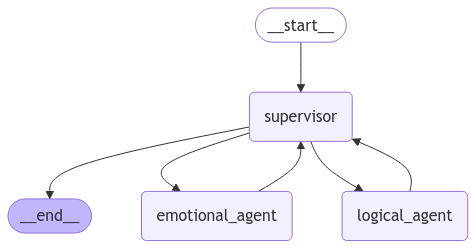

In [22]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)